Nomes :

Antony Muller Pereira

Caio Henrique Sido dos Santos

Edgar Auler Galvão de França

Otávio Scarparo Souza


In [ ]:
#Import das bibliotecas necessarias
import random
import math
import matplotlib as plt
import pandas as pd

In [ ]:
seed = 606

In [ ]:
maxTime = 1800 # 30 Min
clientNum = 1024 # Numero maximo de clientes, na logica que usamos o programa para ou quando atinge o maxTime ou nao tem mais cliente, e 1024 é um numero alto para apenas 1800 segundos
numSims = 1000 # Numero de simulações, cada uma com uma seed diferente
N = clientNum * 3 # Vezes 3 para guardar o tipo do cliente, o TEC e o TS

tipo = client[i][0]

tec  = client[i][1]

ts   = client[i][2]

chegada = client[i][3]

inicio serv = client[i][4]

fim serv = client[i][5]

tempo fila = client[i][6]

tempo total sis = client[i][7]

tempo ocioso = client[i][8]

In [ ]:
#Função que gera o numero aleatorio baseado na seed
def random_number(seed):
    num = seed
    count = 0
    numbers = []
    while(count <= N + 2):
        numbers.append(num/2147483647)
        num = (16807 * num) % (2147483647)
        count += 1
    return numbers[2:]

In [ ]:
# Função que gera o tipo do cliente, seu TEC e seu TS baseado no tipo
def generateType(seed, client):
  generatedNum = random_number(seed)
  for i in range(clientNum):
    client[i][0] = generatedNum[i * 3]
    client[i][1] = generatedNum[i * 3 + 1]
    client[i][2] = generatedNum[i * 3 + 2]
    client[i][1] = -15 * math.log(client[i][1]) # Calculo do TEC é o mesmo para todos os tipos
    if client[i][0] <= 0.6: # Verificação de qual tipo foi gerado e com isso faz o calculo do TS
      client[i][0] = 1
      client[i][2] = -15 * math.log(client[i][2]) + 15
    elif client[i][0] <= 0.9:
      client[i][0] = 2
      client[i][2] = -40 * math.log(client[i][2]) + 30
    else:
      client[i][0] = 3
      client[i][2] = -140 * math.log(client[i][2]) + 60

In [ ]:
#Função que simula a fila por completo, com opção de escolher quantos caixas existem
def calculateTable(seed, cashiers):
  client = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] for _ in range(clientNum)] # Inicializa todas as linhas com 0
  generateType(seed, client) # Gera os clientes, seus tipos TEC e TS
  cashier_available_time = [0] * cashiers  # Todos os caixas sao inicializados com tempo disponivel em 0

  for i in range(clientNum):
    soma = 0
    for j in range(i + 1):# Logica para gerar o tempo de chegada de cada um, fazendo uma soma de todos os valores anteriores e com o atual
      soma += client[j][1]
    client[i][3] = soma

    if client[i][3] > maxTime: # Se o tempo de chegada do cliente atual for maior que o maxTime a simulação para
      del client[i:]
      break

    available_cashier = next((j for j in range(cashiers) if cashier_available_time[j] <= client[i][3]), None) # Retorna o caixa livre se tiver, se não retorna None

    if available_cashier is not None: # Se tiver algum caixa disponivel, atualize o tempo de inicio de serviço e quando aquele caixa for ficar disponivel novamente
      client[i][4] = max(client[i][3], cashier_available_time[available_cashier])  # Tempo de inicio de serviço
      cashier_available_time[available_cashier] = client[i][4] + client[i][2]  # Atualiza a disponibilidade do caixa usando o tempo de inicio de servico e o tempo que vai durar
    else:
      # Todos os caixas estao ocupados
      client[i][4] = min(cashier_available_time)  # O serviço para esse cliente começa quando algum caixa ficar disponivel
      available_cashier = cashier_available_time.index(client[i][4])  # Acha o index desse caixa que vai atender esse cliente
      cashier_available_time[available_cashier] = client[i][4] + client[i][2]  # Atualiza a disponibilidade desse caixa usando o tempo de inicio de serviço e o tempo que vai durar

    # Calculos sobre o restante dos itens
    client[i][5] = client[i][4] + client[i][2] # Fim do serviço para esse cliente
    client[i][6] = max(0, client[i][4] - client[i][3])  # Tempo que ele ficou na fila, se a subtração der negativo o tempo é 0
    client[i][7] = client[i][2] + client[i][6]  # Tempo total que ficou no sistema
    client[i][8] = max(0, client[i][4] - (client[i-1][5] if i > 0 else 0)) if available_cashier is not None and i > 0 and client[i][4] > client[i-1][5] else 0 # Logica para calcular e salvar o tempo ocioso do caixa que atendeu


  # Media da Fila
  sumAvgQueue = [cliente[6] for cliente in client]
  AvgQueue = sum(sumAvgQueue) / len(sumAvgQueue)

  #Media Tempo de servico
  sumAvgSys = [cliente[2] for cliente in client]
  AvgSys = sum(sumAvgSys) / len(sumAvgSys)

  #Media Tempo Total Sistema
  sumAvgTSys = [cliente[7] for cliente in client]
  AvgTSys = sum(sumAvgTSys) / len(sumAvgTSys)

  #Media Tempo Ocioso
  sumAvgOcio = [cliente[8] for cliente in client]
  AvgOcio = sum(sumAvgOcio) / len(sumAvgOcio)

  return (AvgQueue, AvgSys, AvgTSys, AvgOcio) # Retorna somente as medias para calculos futuros

In [ ]:
#Função dos desvio padrao
def desvio_padrao(vector):
    N = len(vector)
    media = sum(vector) / N
    s = 0
    for i in range(N):
      s += (vector[i] - media)**2
    s = math.sqrt(s / (N - 1))
    return s

In [ ]:
#Função que junta tudo e simula
def Gerador(numCashiers):
  resultados = []
  for i in range(numSims):
    resultados.append(calculateTable(seed + i, numCashiers)) #Grava todos os resultados de todas simulações

  # Calcular a média das medias
  AvgAvgQueue = sum([r[0] for r in resultados]) / len(resultados)
  AvgAvgSys = sum([r[1] for r in resultados]) / len(resultados)
  AvgAvgTSys = sum([r[2] for r in resultados]) / len(resultados)
  AvgAvgOcio = sum([r[3] for r in resultados]) / len(resultados)

  #Desvio padrao
  dpQueue = desvio_padrao([r[0] for r in resultados])
  dpSys = desvio_padrao([r[1] for r in resultados])
  dpTSys = desvio_padrao([r[2] for r in resultados])
  dpOcio = desvio_padrao([r[3] for r in resultados])

  # Aqui pra baixo é o calculo do intervalo de credibilidade da simulação inteira com o tempo em minutos
  icQueueTemp = 1.96 * dpQueue / math.sqrt(numSims)
  icSysTemp = 1.96 * dpSys / math.sqrt(numSims)
  icTSysTemp = 1.96 * dpTSys / math.sqrt(numSims)
  icOcioTemp = 1.96 * dpOcio / math.sqrt(numSims)

  icQueue = (AvgAvgQueue - icQueueTemp) / 60, (AvgAvgQueue + icQueueTemp) / 60
  icSys = (AvgAvgSys - icSysTemp) / 60, (AvgAvgSys + icSysTemp) / 60
  icTSys = (AvgAvgTSys - icTSysTemp) / 60, (AvgAvgTSys + icTSysTemp) / 60
  icOcio = (AvgAvgOcio - icOcioTemp) / 60, (AvgAvgOcio + icOcioTemp) / 60

  print(f"Intervalo de Credibilidade da Fila {icQueue}")
  print(f"Intervalo de Credibilidade do Tempo de Servico {icSys}")
  print(f"Intervalo de Credibilidade do Tempo Total de Sistema {icTSys}")
  print(f"Intervalo de Credibilidade do Tempo Ocioso {icOcio}")
  return (icQueue, icSys, icTSys, icOcio)

In [ ]:
print("Gerador com 1 Caixa")
runCashierOne = Gerador(1)
print("Gerador com 2 Caixas")
runCashierTwo = Gerador(2)
print("Gerador com 3 Caixas")
runCashierThree = Gerador(3)

Gerador com 1 Caixa
Intervalo de Credibilidade da Fila (42.95189552759987, 44.04379962529424)
Intervalo de Credibilidade do Tempo de Servico (0.9756025415238753, 0.9887668075469814)
Intervalo de Credibilidade do Tempo Total de Sistema (43.92951008884277, 45.030554413122346)
Intervalo de Credibilidade do Tempo Ocioso (0.0003182368338086905, 0.0005153672437265038)
Gerador com 2 Caixas
Intervalo de Credibilidade da Fila (13.811424210491161, 14.341357714790096)
Intervalo de Credibilidade do Tempo de Servico (0.9756025415238753, 0.9887668075469814)
Intervalo de Credibilidade do Tempo Total de Sistema (14.789111393325726, 15.328039881026388)
Intervalo de Credibilidade do Tempo Ocioso (0.0010142649075210036, 0.0013420082968644202)
Gerador com 3 Caixas
Intervalo de Credibilidade da Fila (4.691487688377669, 5.0036518896817475)
Intervalo de Credibilidade do Tempo de Servico (0.9756025415238753, 0.9887668075469814)
Intervalo de Credibilidade do Tempo Total de Sistema (5.669144944537473, 5.9903639

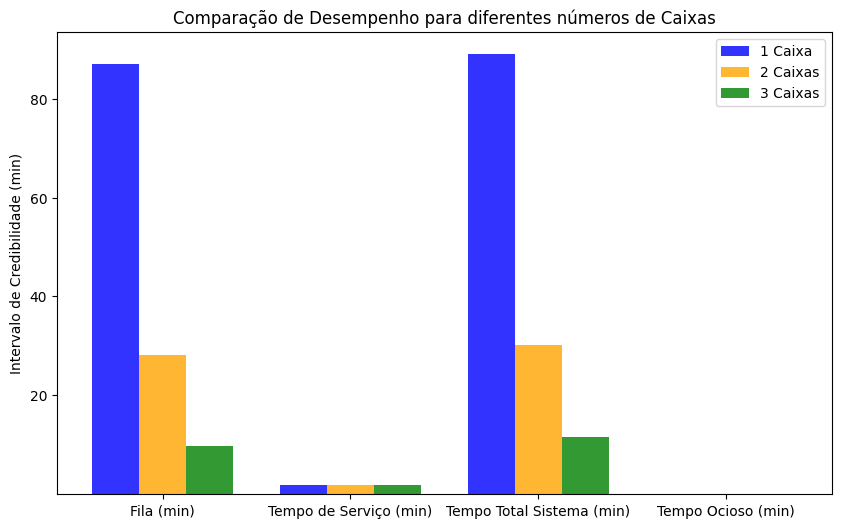

In [ ]:
# prompt: faça um grafico de barras 1 Caixa(Fila, Tempo de Serviço, Tempo Total Sistema, Tempo Ocioso); 2 Caixa(Fila, Tempo de Serviço, Tempo Total Sistema, Tempo Ocioso);3 Caixa(Fila, Tempo de Serviço, Tempo Total Sistema, Tempo Ocioso)

import matplotlib.pyplot as plt
import numpy as np

# Dados dos intervalos de credibilidade para cada número de caixas
data = {
    '1 Caixa': [runCashierOne[0], runCashierOne[1], runCashierOne[2], runCashierOne[3]],
    '2 Caixas': [runCashierTwo[0], runCashierTwo[1], runCashierTwo[2], runCashierTwo[3]],
    '3 Caixas': [runCashierThree[0], runCashierThree[1], runCashierThree[2], runCashierThree[3]]
}

# Labels das barras
labels = ['Fila (min)', 'Tempo de Serviço (min)', 'Tempo Total Sistema (min)', 'Tempo Ocioso (min)']

# Cores das barras para cada caixa
colors = ['blue', 'orange', 'green']

# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(10, 6))

# Largura das barras
bar_width = 0.25

# Posições das barras no eixo x
x = np.arange(len(labels))

# Iterar pelos dados de cada caixa e criar as barras
for i, (caixa, results) in enumerate(data.items()):
    ax.bar(x + i * bar_width, [result[0] for result in results], width=bar_width, color=colors[i], label=caixa, alpha=0.8)
    ax.bar(x + i * bar_width, [result[1] for result in results], width=bar_width, color=colors[i], bottom=[result[0] for result in results], alpha=0.8)

# Adicionar legenda, rótulos dos eixos e título
ax.set_ylabel('Intervalo de Credibilidade (min)')
ax.set_title('Comparação de Desempenho para diferentes números de Caixas')
ax.set_xticks(x + bar_width)
ax.set_xticklabels(labels)
ax.legend()

# Mostrar o gráfico
plt.show()

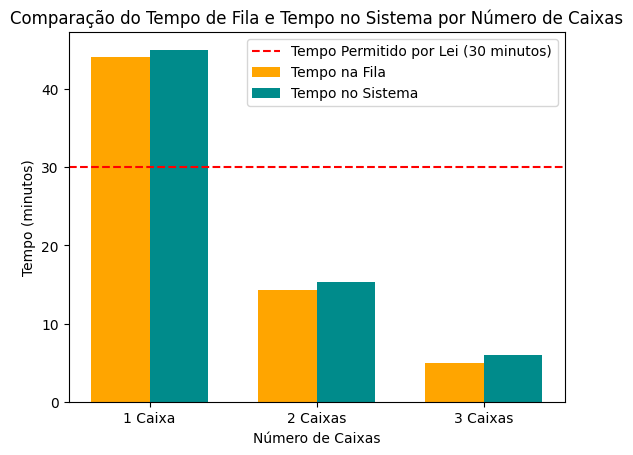

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

filaOne =  runCashierOne[0][1]
sistemaOne = runCashierOne[2][1]

filaTwo = runCashierTwo[0][1]
sistemaTwo = runCashierTwo[2][1]

filaThree = runCashierThree[0][1]
sistemaThree = runCashierThree[2][1]

labels = ['1 Caixa', '2 Caixas', '3 Caixas']

queueData = [filaOne, filaTwo, filaThree]
sysData = [sistemaOne, sistemaTwo, sistemaThree]

barWidth = 0.35

x = np.arange(len(labels))

fig, ax = plt.subplots()

barsQueue = ax.bar(x - barWidth/2, queueData, barWidth, label='Tempo na Fila', color='orange')
barsSys = ax.bar(x + barWidth/2, sysData, barWidth, label='Tempo no Sistema', color='darkcyan')

ax.axhline(y=30, color='r', linestyle='--', label='Tempo Permitido por Lei (30 minutos)')

ax.set_title('Comparação do Tempo de Fila e Tempo no Sistema por Número de Caixas')
ax.set_xlabel('Número de Caixas')
ax.set_ylabel('Tempo (minutos)')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend()

plt.show()